In [1]:
import os
import pandas as pd
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from config.read_config import get_database_config

"""
This Python script downloads data from the Pecan Street Inc DataPort database directly
and uses Pandas and Matplotlib to plot average solar production per hour during several
days in August 2017 covering the day of the solar eclipse (21st).
First it gathers a set of homes by dataid from other_datasets.metadata for the date range
that have grid (whole home electrical grid usage), solar, are in the city of Austin,
and have very complete data.
From that set of dataids, we select:
local_15min : the datetime stamp of the record
air1: the usage of the air conditioner (not used here)
car1: the usage of the electrical vehicle charger (not used here)
grid: the usage of the whole home from the electrical grid (not used here)
solar: solar production 
We group the days and group the hours of solar production and take the mean for every hour across all of the homes
and plot that. 
The other unused circuits are there for your convenience.
Please feel free to expand on this or create other examples and submit them by pull request!
"""


me = os.path.basename(__file__)

try:
    # !! Go set your username, password, host, port, and database name in the config/config.txt file!
    database_config = get_database_config("../../config/config.txt")

    engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))

    # let's select some homes for the a few days of Aug2017 that have grid data that's very complete,
    # and have pv, and solar
    query = """SELECT dataid, local_15min, air1, car1, grid, solar 
            FROM electricity.eg_realpower_15min
            WHERE extract(month from local_15min) = 8 AND local_15min >= '2017-08-19' AND local_15min < '2017-08-24' 
            AND dataid IN(
            	SELECT dataid
            	FROM other_datasets.metadata where 
            	egauge_1min_min_time < '2017-08-19' AND egauge_1min_max_time >= '2017-08-24'
                AND grid is not null
                AND solar is not null
                AND city = 'Austin'
                AND (
                    egauge_1min_data_availability like '100%' OR
                    egauge_1min_data_availability like '99%' OR
                    egauge_1min_data_availability like '98%' 
                    )
            );"""

    # create a dataframe with the data from the sql query
    df = pd.read_sql_query(sqla.text(query), engine)

    print(df.describe())

    # set the index to the timestamps
    df = df.set_index('local_15min')
    # convert to US Central time from UTC
    df = df.tz_convert('US/Central')
    print("DataFrame info:")
    print(df.info())

    # group the data hours and take the mean of those to get kWh
    days = df.groupby(pd.Grouper(freq='H')).mean()

    # create the plot
    # Use seaborn style defaults and set the default figure size
    sns.set(rc={'figure.figsize': (11, 4)})
    solar_plot = days['solar'].plot(linewidth=0.5, marker='.')
    solar_plot.set_xlabel('Date')
    solar_plot.set_ylabel('Solar Production kWh')
    solar_plot.set_title('Solar Production During Aug,21 2017 Eclipse')

    # display the plot
    plt.show()

    print('Done')
    exit(0)


except psycopg2.Error as dbe:
    traceback.print_exc()
    print("Error connecting to database from {}.".format(me))

ModuleNotFoundError: No module named 'psycopg2'

In [3]:
database_config = get_database_config("./config/config.txt")

NameError: name 'get_database_config' is not defined

In [3]:
pip install psycopg2

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# This constant limits the number of rows read in from the big CSV file.
# Set to None if you want to read the whole thing
LIMIT = 100000

if not os.path.isfile('metadata.csv'):
    print("Could not find metadata.csv file in {} .".format(os.getcwd()))
    exit(1)
if not os.path.isfile('15minute_data_austin.csv'):
    print("Could not find 15minute_data_austin.csv file in {} .".format(os.getcwd()))
    exit(1)

# read in the metadata file, skip the 2nd row because it has the comments further describing the headers
metadata = pd.read_csv('metadata.csv', engine='python', encoding="ISO-8859-1", skiprows=[1])


# filter down to our houses of interest. Active, Austin-based, has complete data, and has the grid circuit
dataids = metadata[metadata.active_record.eq('yes') &
                   metadata.city.eq('Austin') &
                   metadata.egauge_1min_data_availability.isin(['100%', '99%', '98%', '97%']) &
                   metadata.grid.eq('yes')]


# read the 15 minute data file for Austin
all_data = pd.read_csv('15minute_data_austin.csv', engine='python', encoding="ISO-8859-1",
                                  parse_dates=['local_15min'], index_col=['local_15min'],
                                  usecols=['dataid', 'local_15min', 'grid'],
                                  nrows=LIMIT)

# filter down to the dataids we're interested in
filt = all_data[all_data.dataid.isin(dataids.dataid)]

filt.index = pd.to_datetime(filt.index, utc=True, infer_datetime_format=True)
filt = filt.tz_convert('US/Central')

print(filt.describe())

# group the data by days and take the mean of those
days = filt.groupby(pd.Grouper(freq='D')).mean()

# convert from kW to kWh
days['grid_kwh'] = days['grid'].apply(lambda x: x * 24)

print(days.describe())

# create the plot
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize': (11, 4)})
solar_plot = days['grid_kwh'].plot(linewidth=0.5, marker='.')
solar_plot.set_xlabel('Date')
solar_plot.set_ylabel('Grid Usage kWh')
solar_plot.set_title('Average Grid Usage in Austin, TX')

# display the plot
plt.show()

print('done')

Could not find metadata.csv file in C:\Users\Jon Day\Documents\EE555\ee555\EE555-FinalProject .
Could not find 15minute_data_austin.csv file in C:\Users\Jon Day\Documents\EE555\ee555\EE555-FinalProject .


FileNotFoundError: [Errno 2] No such file or directory: 'metadata.csv'

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import traceback
import sqlalchemy as sqla
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Function that performs one iteration of gradient descent to improve the model parameters:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


df = pd.read_csv('load_per_country.csv', parse_dates=['DateTime'], index_col = ['DateTime'])
select = df[['PL','DE']]

select_2012 = select.loc['2012-01-01':'2015-12-31']


nonan = select_2012.dropna()
nonan = nonan.groupby(pd.Grouper(level='DateTime', axis=0, freq='24H')).sum()
print(nonan)

x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['PL'].values,test_size=0.2)

                  PL         DE
DateTime                       
2012-01-01  322427.0   953331.0
2012-01-02  411893.0  1259040.0
2012-01-03  433851.0  1335540.0
2012-01-04  440509.0  1345656.0
2012-01-05  442268.0  1376762.0
...              ...        ...
2015-12-27  328159.0  1067776.0
2015-12-28  400402.0  1215866.0
2015-12-29  416257.0  1234045.0
2015-12-30  422671.0  1237287.0
2015-12-31  387856.0  1158909.0

[1461 rows x 2 columns]


In [9]:
print(nonan.values)
print(nonan.iloc[:, 1:].values)
print(nonan.iloc[:, :1].values)
#x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, 1:].values, nonan['PL'].values,test_size=0.2)

[[ 322427.  953331.]
 [ 411893. 1259040.]
 [ 433851. 1335540.]
 ...
 [ 416257. 1234045.]
 [ 422671. 1237287.]
 [ 387856. 1158909.]]
[[ 953331.]
 [1259040.]
 [1335540.]
 ...
 [1234045.]
 [1237287.]
 [1158909.]]
[[322427.]
 [411893.]
 [433851.]
 ...
 [416257.]
 [422671.]
 [387856.]]


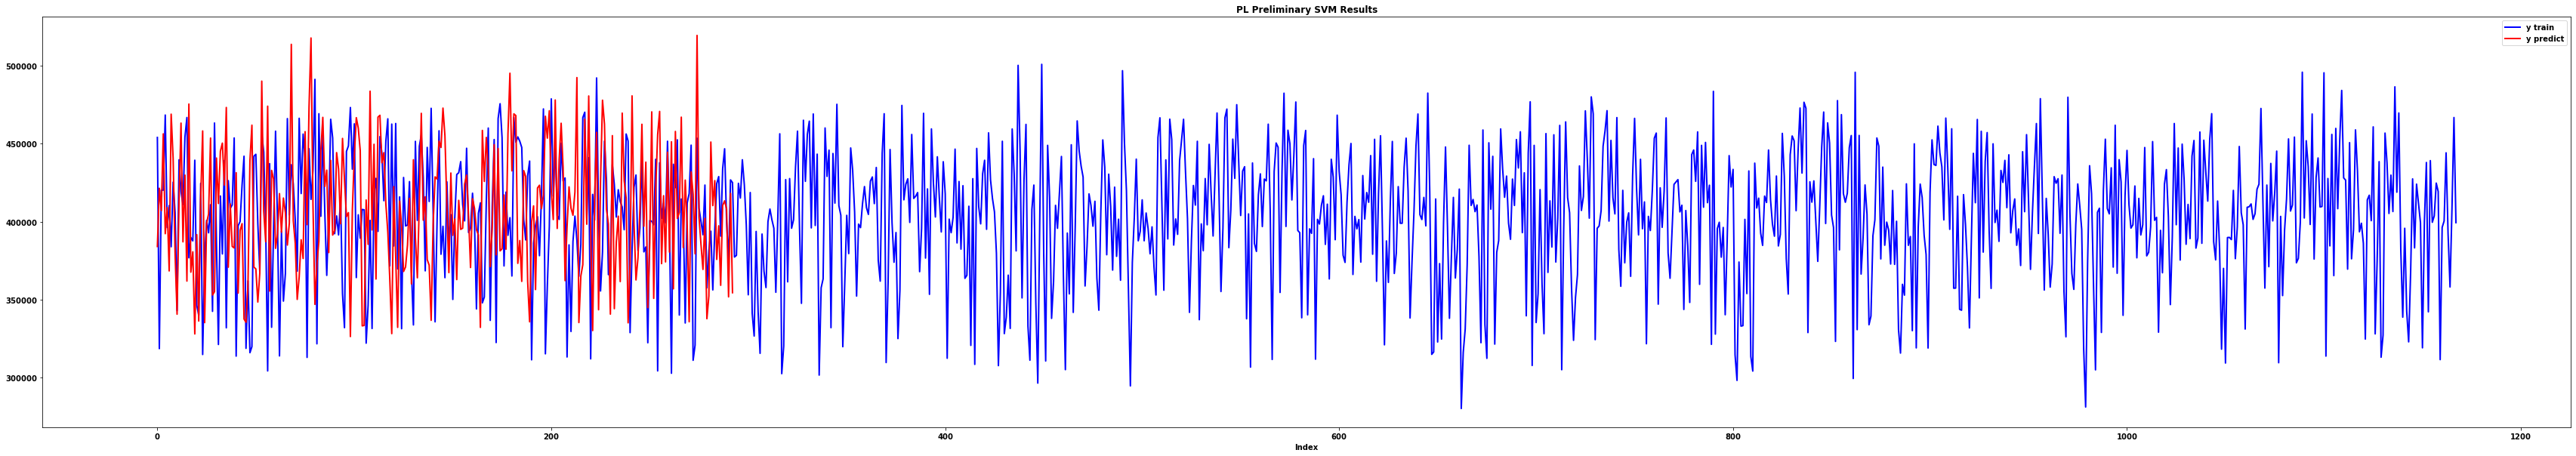

In [40]:
x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['PL'].values,test_size=0.2)

svr = SVR(kernel="poly").fit(x_train, y_train)
y_train_predict=svr.predict(x_test)

plt.plot( y_train, lw=2, color="blue", label="y train")
plt.plot( y_train_predict, lw=2, color="red", label="y predict")
plt.legend()
plt.title("PL Preliminary SVM Results")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [41]:
def plot_points(X, y):
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'blue', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'red', edgecolor = 'k')

def display(m, b, color='g--'):
    plt.xlim(-0.05,1.05)
    plt.ylim(-0.05,1.05)
    x = np.arange(-10, 10, 0.1)
    plt.plot(x, m*x+b, color)

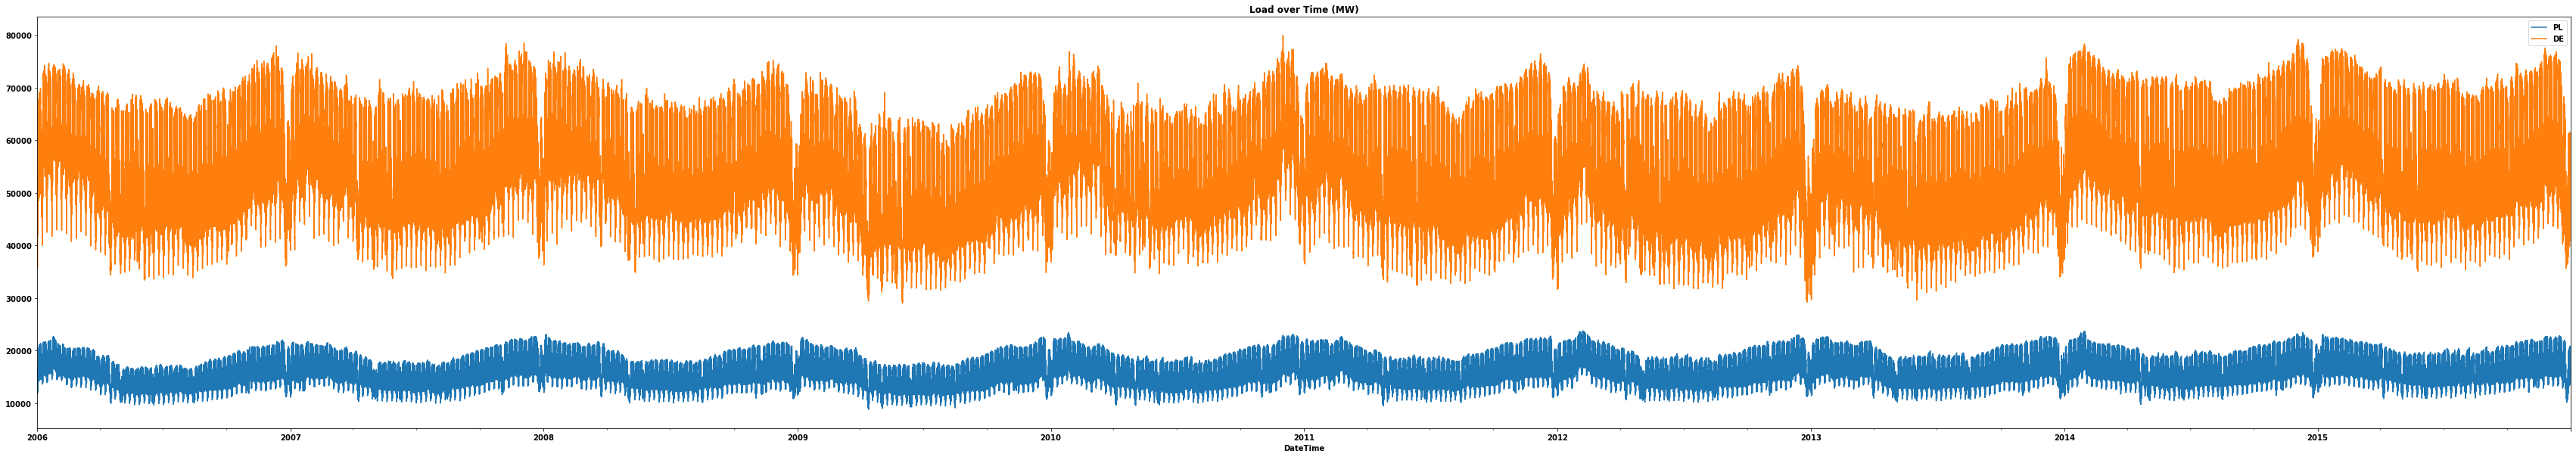

In [42]:
select.plot()
plt.legend()
plt.title("Load over Time (MW)")
plt.show()

In [23]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def output_formula(features, weights, bias):
    return sigmoid(np.dot(features, weights) + bias)

def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

def update_weights(x, y, weights, bias, learnrate):
    output = output_formula(x, weights, bias)
    d_error = y - output
    weights += learnrate * d_error * x
    bias += learnrate * d_error
    return weights, bias

In [26]:
np.random.seed(44)

epochs = 100
learnrate = 0.01

def train(features, targets, epochs, learnrate, graph_lines=False):
    
    errors = []
    n_records, n_features = features.shape
    last_loss = None
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)
    bias = 0
    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for x, y in zip(features, targets):
            weights, bias = update_weights(x, y, weights, bias, learnrate)
        
        # Printing out the log-loss error on the training set
        out = output_formula(features, weights, bias)
        loss = np.mean(error_formula(targets, out))
        errors.append(loss)
        if e % (epochs / 10) == 0:
            print("\n========== Epoch", e,"==========")
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            
            # Converting the output (float) to boolean as it is a binary classification
            # e.g. 0.95 --> True (= 1), 0.31 --> False (= 0)
            predictions = out > 0.5
            
            accuracy = np.mean(predictions == targets)
            print("Accuracy: ", accuracy)
        #if graph_lines and e % (epochs / 100) == 0:
        #    display(-weights[0]/weights[1], -bias/weights[1])
            

    # Plotting the solution boundary
    plt.title("Solution boundary")
    display(-weights[0]/weights[1], -bias/weights[1], 'black')

    # Plotting the data
    plot_points(features, targets)
    plt.show()

    # Plotting the error
    plt.title("Error Plot")
    plt.xlabel('Number of epochs')
    plt.ylabel('Error')
    plt.plot(errors)
    plt.show()

C:\Python\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\Python\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  



========== Epoch 0 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 10 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 20 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 30 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 40 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 50 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 60 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 70 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 80 ==========
Train loss:  -inf
Accuracy:  0.0

========== Epoch 90 ==========
Train loss:  -inf
Accuracy:  0.0


IndexError: index 1 is out of bounds for axis 0 with size 1

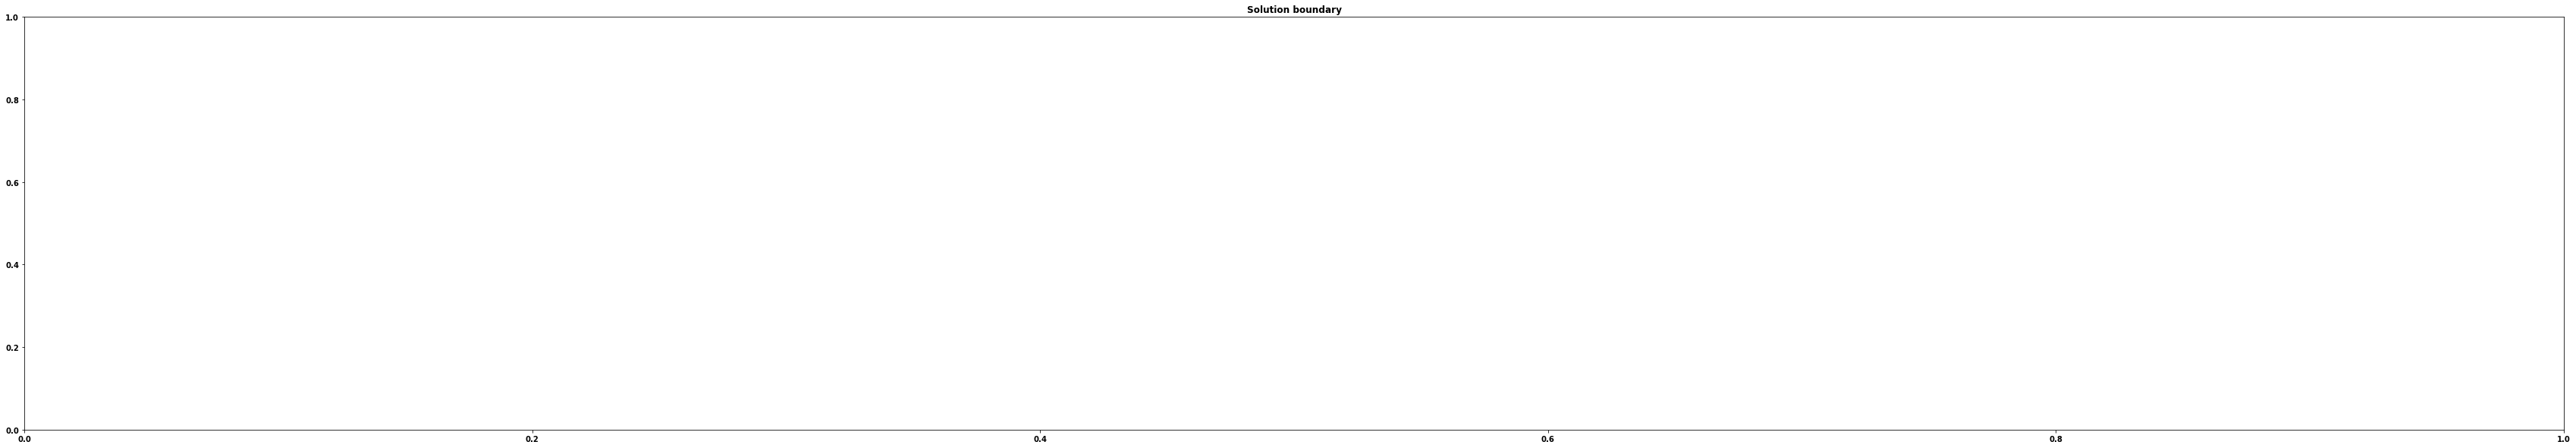

In [27]:
train(x_train, y_train, epochs, learnrate, True)

In [358]:
x_train, x_test, y_train, y_test = train_test_split(nonan.iloc[:, :1].values, nonan['PL'].values,test_size=0.795)

X_train_torch = torch.tensor(x_train).float()
Y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(x_test).float()
Y_test_torch = torch.tensor(y_test).float()
nbus = 299

In [330]:
len(y_train)

299

In [331]:
len(y_test)

1162

In [332]:
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 299
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus),
        )

    def forward(self, x): 
        return self.model(x)

C:\Python\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([299])) that is different to the input size (torch.Size([1, 299])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training error:  0.0003135451697744429


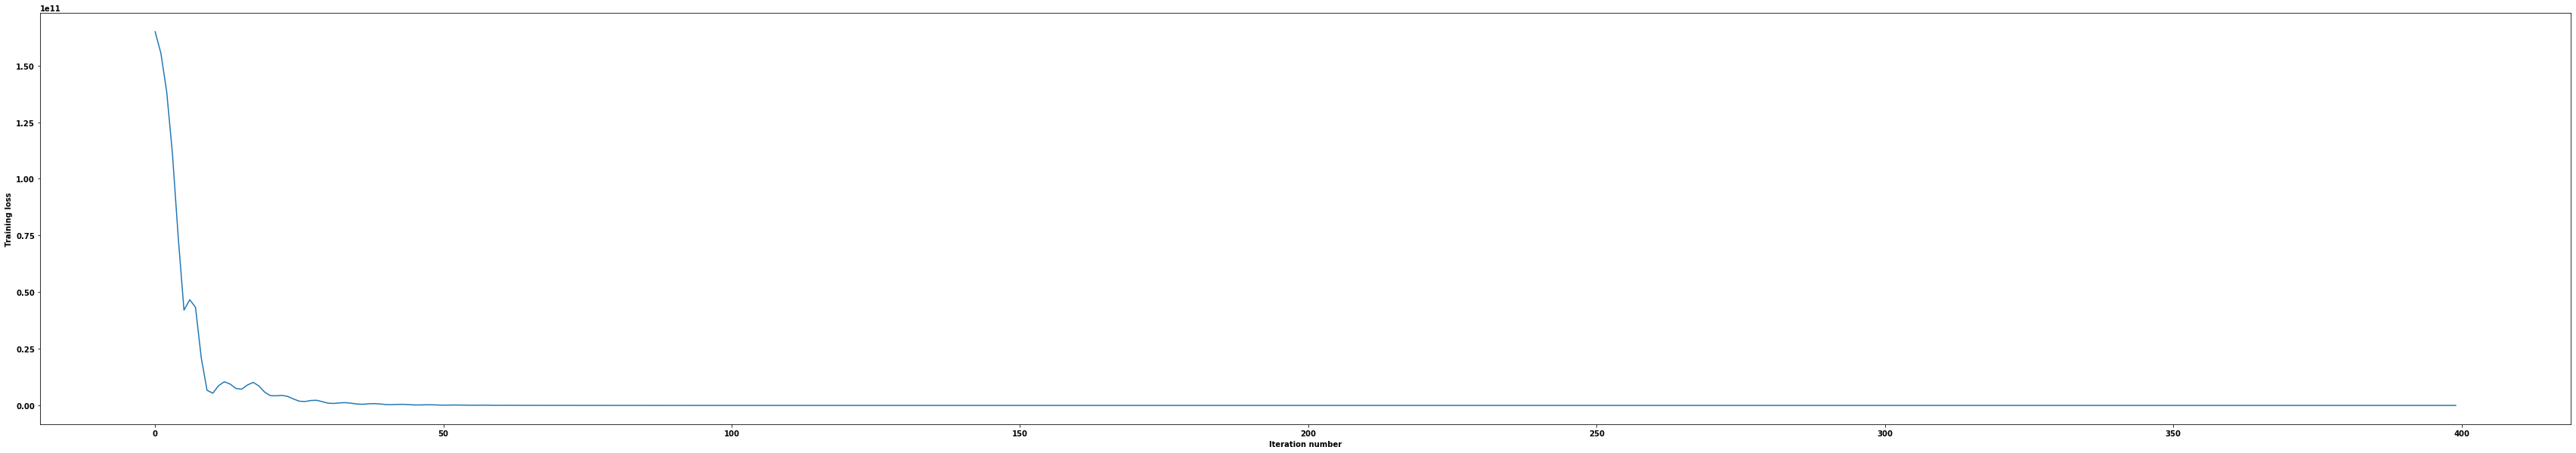

In [333]:
# Loss function for training:
loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 400
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torch.T,Y_train_torch)
    
Y_hat_train = net(X_train_torch.T)
#Y_hat_test = net(X_test_torch.T)
print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/len(x_train)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

In [334]:
y_pred = []
for i in range(len(Y_hat_train)):
    #print(loss_traj[i])
    a = Y_hat_train[i].detach()
    y_pred.append(a)

In [335]:
#print(y_pred)
print(Y_hat_train[0][0])

tensor(316560., grad_fn=<SelectBackward0>)


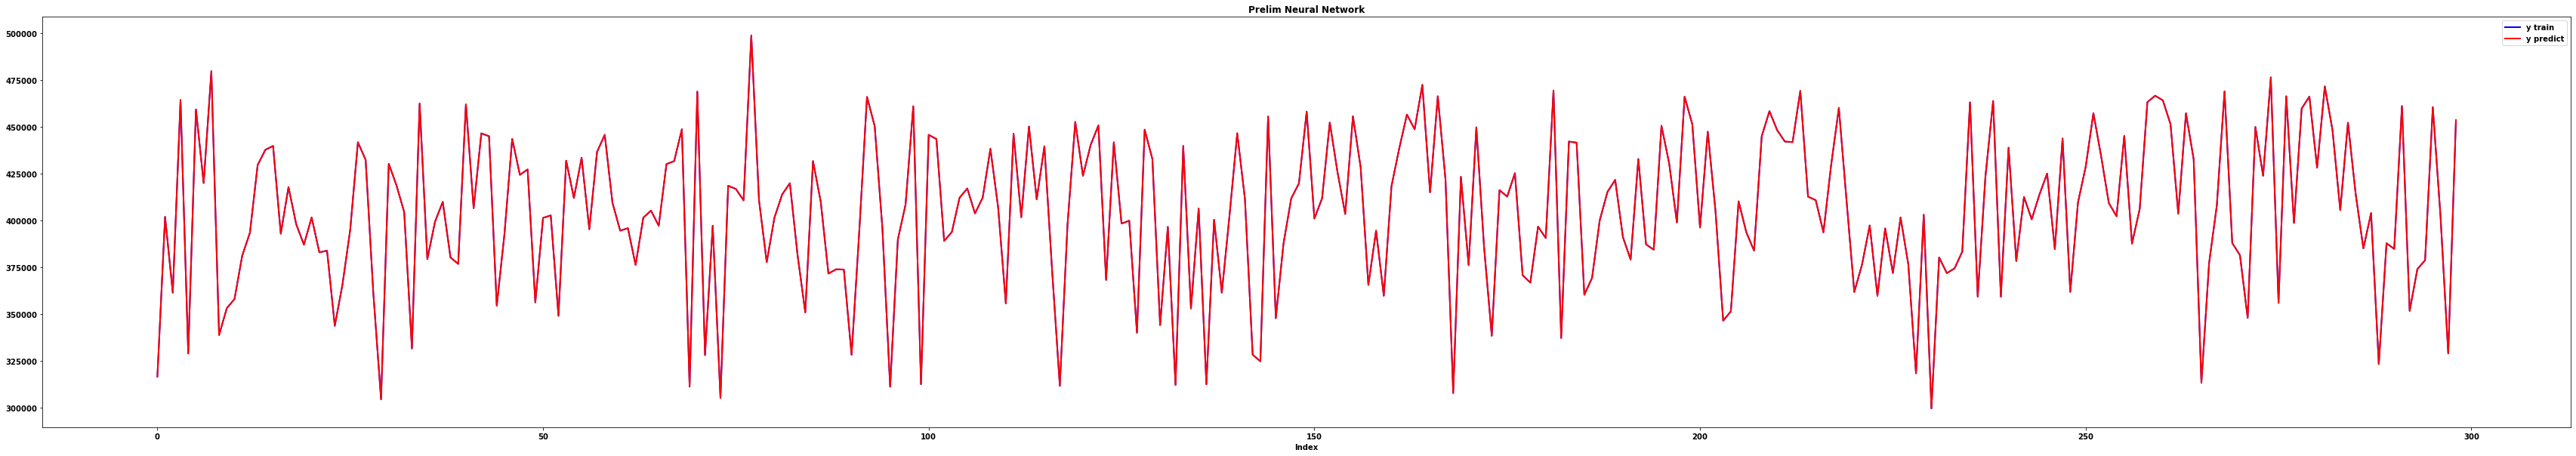

In [336]:
plt.plot( Y_train_torch, lw=2, color="blue", label="y train")
plt.plot( y_pred[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

C:\Python\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([299])) that is different to the input size (torch.Size([1, 299])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training error:  0.015768708661198616


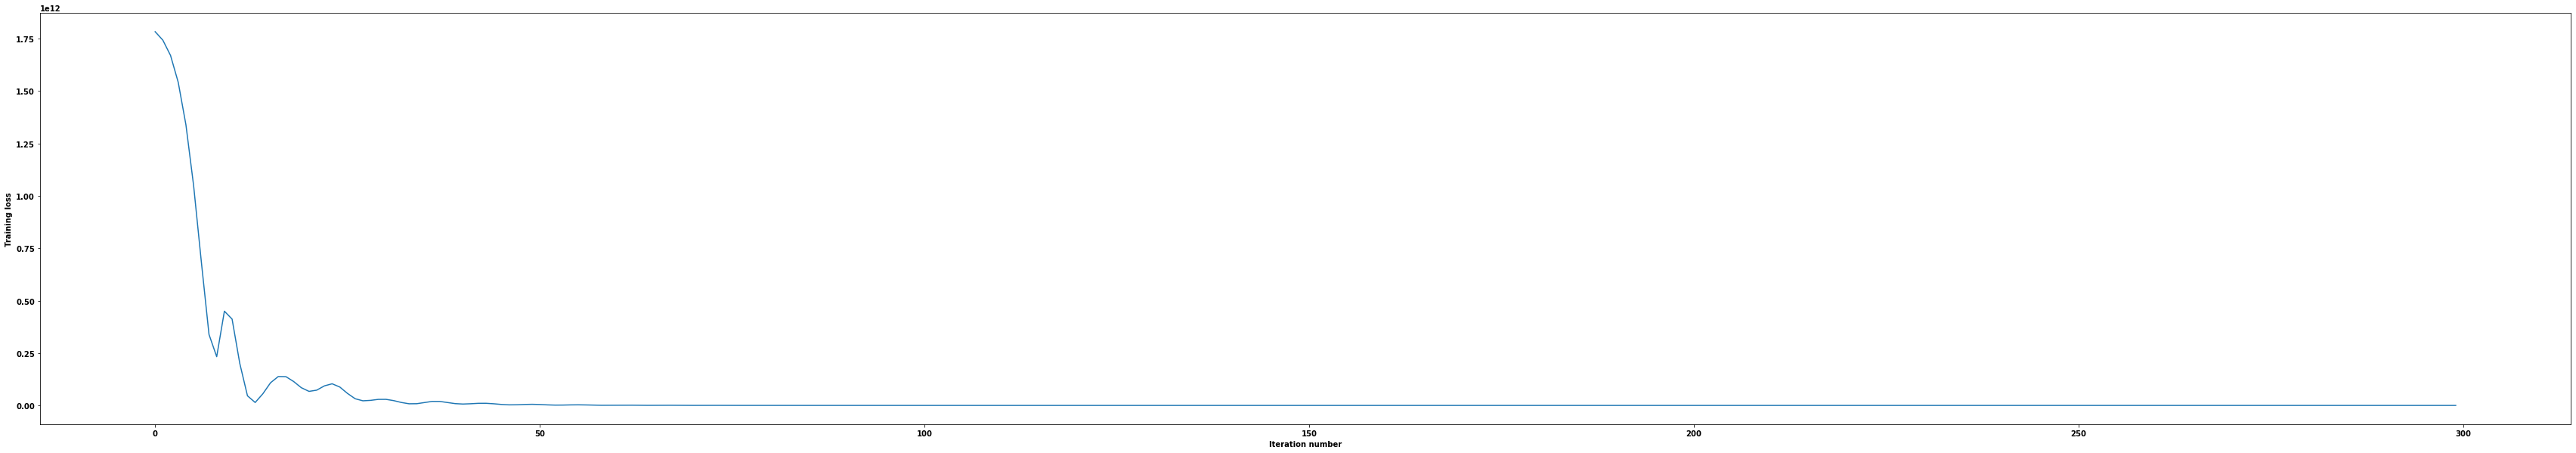

In [396]:
x_trainDE, x_testDE, y_trainDE, y_testDE = train_test_split(nonan.iloc[:, :1].values, nonan['DE'].values,test_size=0.795)

X_train_torchDE = torch.tensor(x_trainDE).float()
Y_train_torchDE = torch.tensor(y_trainDE).float()
X_test_torchDE = torch.tensor(x_testDE).float()
Y_test_torchDE = torch.tensor(y_testDE).float()


nbus = 299
def train_loop(net,loss_fn,optimizer,X_train,Y_train):
    pred = net(X_train) # this calls the net.forward function, returning one prediction for each row of X.
    loss = loss_fn(pred, Y_train) # compute the loss associated with the predictions
    loss_traj.append(loss) # Record the loss at each iteration

    # Gradient descent
    optimizer.zero_grad() # Reset the gradients to zero
    loss.backward() # Compute the gradient of the loss with respect to each weight in the network
    optimizer.step() # Take a gradient step


class state_net(nn.Module): 
    def __init__(self):
        super(state_net, self).__init__()
        n_hidden = 299
        self.model = nn.Sequential(
            nn.Linear(nbus,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,nbus),
        )

    def forward(self, x): 
        return self.model(x)

loss_fn = nn.MSELoss()

net = state_net() # Create neural network

# Create an 'optimizer' object for training:
learning_rate = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss_traj = []
    
T = 300
for t in range(T):
    train_loop(net,loss_fn,optimizer,X_train_torchDE.T,Y_train_torchDE)

Y_hat_trainDE = net(X_train_torchDE.T)
#Y_hat_test = net(X_test_torch.T)
print("Training error: ", (torch.linalg.norm(Y_hat_trainDE-Y_train_torchDE,ord='fro')**2/len(x_trainDE)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_predDE = []
for i in range(len(Y_hat_trainDE)):
    #print(loss_traj[i])
    a = Y_hat_trainDE[i].detach()
    y_predDE.append(a)


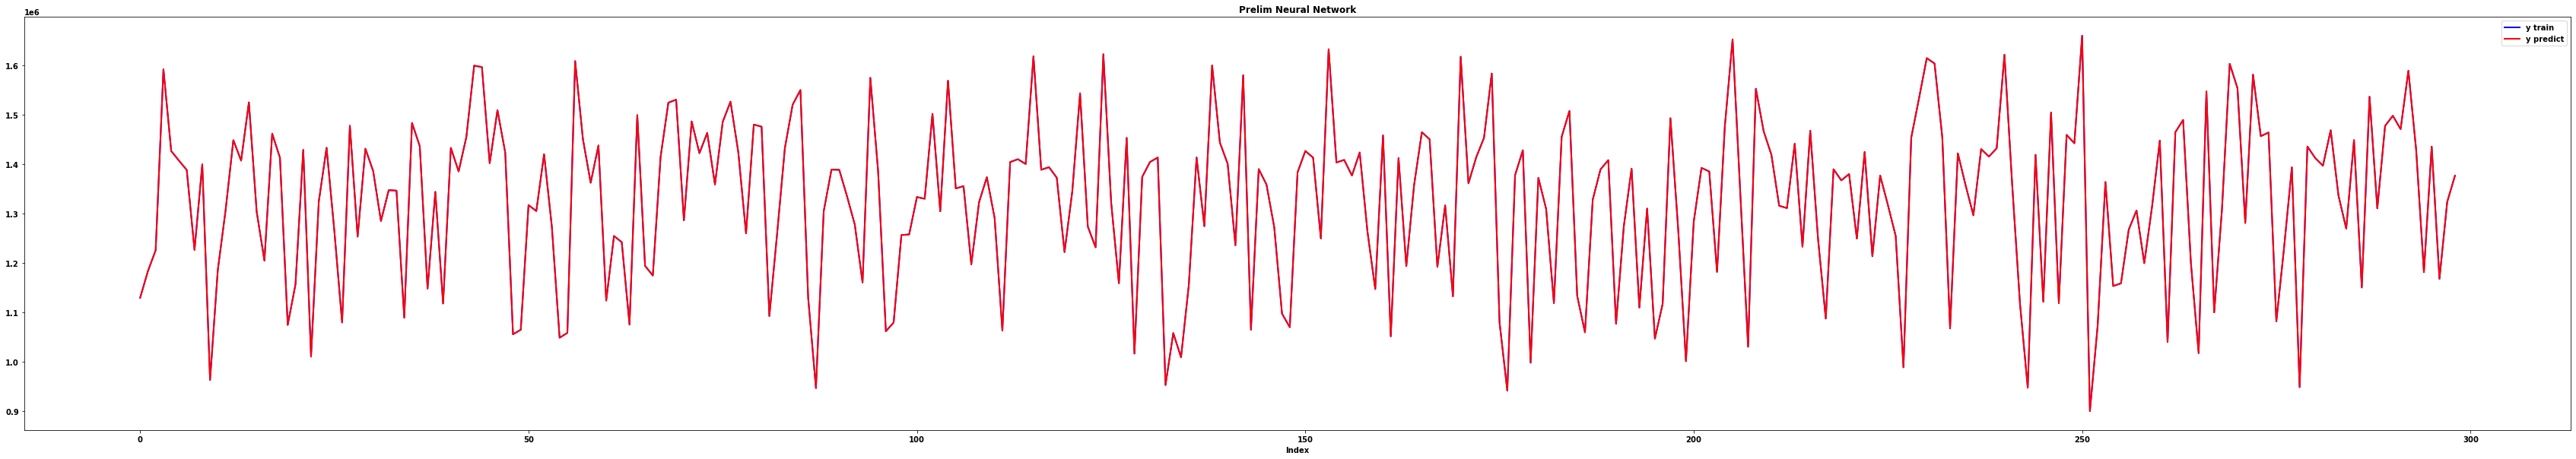

In [397]:
plt.plot( Y_train_torchDE, lw=2, color="blue", label="y train")
plt.plot( y_predDE[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

In [398]:
Y_hat_train = net(X_train_torch.T)

Training error:  850098651136.0


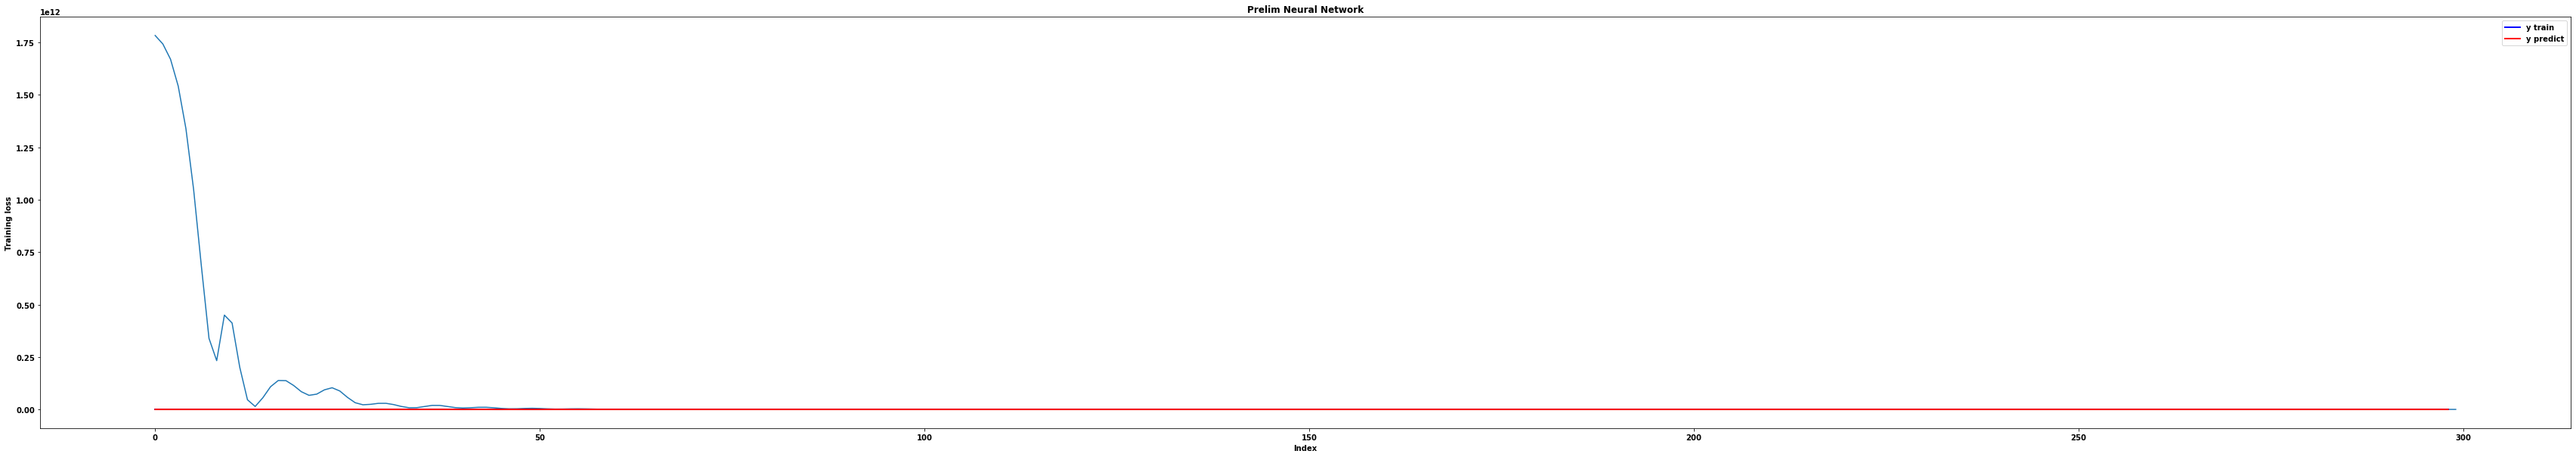

In [399]:
print("Training error: ", (torch.linalg.norm(Y_hat_train-Y_train_torch,ord='fro')**2/len(x_train)).item())
#print("Test error: ", (torch.linalg.norm(Y_hat_test-Y_test_torch,ord='fro')**2/(M-n)).item())
loss_traj2 = []
for i in range(len(loss_traj)):
    #print(loss_traj[i])
    a = loss_traj[i].detach()
    loss_traj2.append(a)
plt.plot(loss_traj2)
#plt.plot(loss_traj)
plt.xlabel('Iteration number')
plt.ylabel('Training loss');

y_pred = []
for i in range(len(Y_hat_train)):
    #print(loss_traj[i])
    a = Y_hat_train[i].detach()
    y_pred.append(a)

plt.plot( Y_train_torch, lw=2, color="blue", label="y train")
plt.plot( y_pred[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()

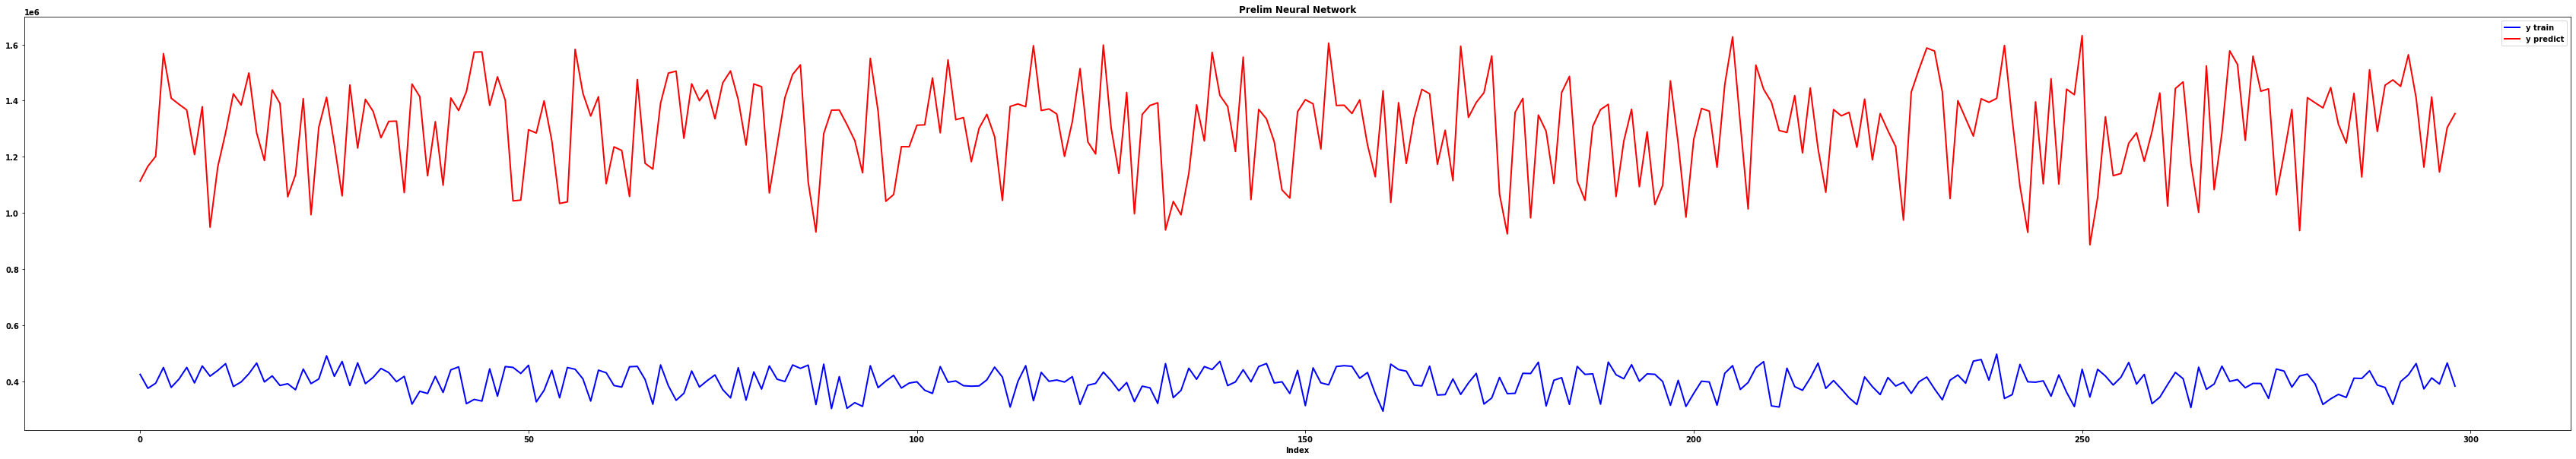

In [400]:
plt.plot( Y_train_torch, lw=2, color="blue", label="y train")
plt.plot( y_pred[0], lw=2, color="red", label="y predict")
plt.legend()
plt.title("Prelim Neural Network")
plt.xlabel("Index")
plt.rcParams["figure.figsize"] = (60,10)
plt.show()